In [1]:
head = ['year','month','day','P','evap','runoff','baseflow','swe','soil_moist1','soil_moist2',
        'soil_moist3','Net_Radiation','Sensible_Heat_Flux','Latent_Heat_Flux','Ground_Heat_Flux','Albedo']

data = pd.read_excel('./Livneh_Q1_wbal_39.0625_-108.3125.xls')
data.index = pd.DatetimeIndex(pd.date_range(start = '1920-1-1',periods=len(data),freq='D'))
data.columns = head

In [2]:
data['Q'] = data['baseflow'] + data['runoff']

In [3]:
data2 = data.groupby('year').sum()

In [4]:
import statsmodels.api as sm

In [5]:
sm.tsa.stattools.adfuller(data2.Q,regression='nc',autolag='AIC') # ADF test on annual Q

(-2.6454350135420741,
 0.0079173835068302115,
 2,
 87,
 {'1%': -2.591918042013476,
  '10%': -1.6140871766111924,
  '5%': -1.9444845177622578},
 664.88133886625224)

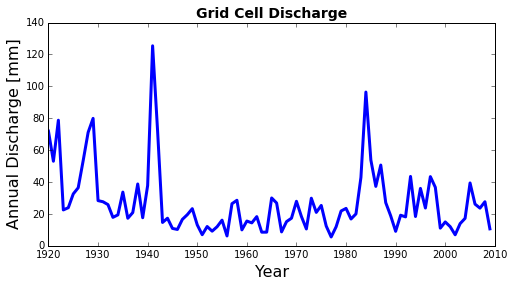

In [6]:
plt.figure(figsize=(8,4))
plt.plot(data2.index, data2.Q, lw =3)
plt.xlabel('Year', fontsize=16)
plt.ylabel('Annual Discharge [mm]', fontsize = 16)
plt.title('Grid Cell Discharge',fontsize = 14, fontweight='bold')
plt.savefig('./annual_q.png', dpi=300, bbox_in='tight')

In [7]:
sm.tsa.stattools.adfuller(data2.P,regression='nc',autolag='AIC') # ADF test on annual precipitation

(-0.74830075218247538,
 0.39225979709699799,
 9,
 80,
 {'1%': -2.5942542187499997,
  '10%': -1.6138745234374998,
  '5%': -1.944822298828125},
 947.28656022270548)

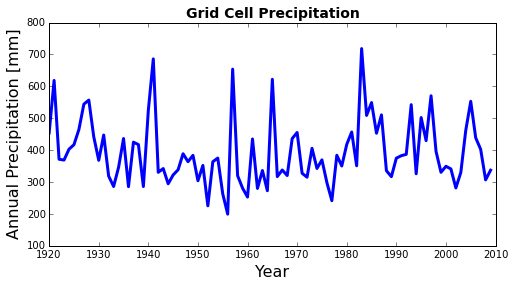

In [8]:
plt.figure(figsize=(8,4))
plt.plot(data2.index, data2.P, lw =3)
plt.xlabel('Year', fontsize=16)
plt.ylabel('Annual Precipitation [mm]', fontsize = 16)
plt.title('Grid Cell Precipitation',fontsize = 14, fontweight='bold')
plt.savefig('./annual_p.png', dpi=300, bbox_in='tight')

In [9]:
data2['Q_P'] = data2.Q/data2.P # compute runoff ratios

In [10]:
data2['e'] = np.NaN

In [11]:
for year in np.arange(1921,2010): # compute interannual changes in P and Q for elasticity
    prev_year = year-1
    delp = data2.loc[year,'P'] - data2.loc[prev_year,'P']
    delq = data2.loc[year,'Q'] - data2.loc[prev_year,'Q']
    
    data2.loc[year,'e'] = delq/delp

In [12]:
# numerically invert the budyko equation to get aridity values given ET/P

A = np.arange(0,20.00001,0.00001)
E = np.sqrt(A*np.tanh(1/A)*(1-np.exp(-A)))

In [13]:
data2['E'] = data2['evap']/data2['P'] # compute the evaporative index for each site

In [14]:
data2.loc[data2.E > 1.0,'E'] = np.NaN # clean E values greater than 1

In [15]:
# use a finder function to get the aridity index value for each year using the budyko equation

data2['A'] = np.NaN

for year in np.arange(1920,2010): #loop through each year
    
    if np.isnan(data2.loc[year,'E']):
        data2.loc[year,'A'] = np.NaN
    else:
        tmp = np.abs(E - data2.loc[year,'E'])
        find = min(tmp)
        data2.loc[year,'A'] = A[tmp == find]

In [16]:
data2.A.mean() # compute mean aridity index

2.209609454545455

In [17]:
def get_decade(year):
    idx=str(year)
    
    if int(idx[0:2]) < 20:
        return int('19'+idx[2:3]+'0')
    else:
        return int('20'+idx[2:3]+'0')

In [18]:
data3 = data2.reset_index()

In [19]:
data3['decade'] = data3.year.apply(get_decade)

In [20]:
data4 = data3.groupby('decade').mean()

In [21]:
data4

,year,month,day,P,evap,runoff,baseflow,swe,soil_moist1,soil_moist2,...,Net_Radiation,Sensible_Heat_Flux,Latent_Heat_Flux,Ground_Heat_Flux,Albedo,Q,Q_P,e,E,A
decade,,,,,,,,,,,,,,,,,,,,,
1920,1924.5,2382.6,5746.7,464.0175,413.58102,5.63058,46.72708,4450.24910,8675.01437,34150.43457,...,28108.38508,-1268.92415,11657.61743,-360.34862,127.95309,52.35766,0.113991,2.678667,0.869184,1.973843
1930,1934.5,2382.4,5743.8,361.6225,345.53037,2.51210,22.21003,2719.58101,8325.18590,31900.85989,...,28959.64846,-1116.03952,9710.47396,-253.42821,118.49751,24.72213,0.067951,-0.089671,0.895102,2.927343
1940,1944.5,2382.6,5746.7,397.5450,364.52389,3.55501,31.25270,2019.94072,8400.21056,32042.57255,...,28968.32745,-865.45369,10246.01845,-255.82038,112.62865,34.80771,0.079639,-0.419812,0.849324,2.069808
1950,1954.5,2382.4,5743.8,333.7350,318.71681,1.88309,12.17039,2043.95454,8111.28633,30289.82519,...,28838.84475,-936.43842,8834.36232,-225.27541,112.05914,14.05348,0.043113,0.081457,0.819853,1.831432
1960,1964.5,2382.6,5746.7,361.0175,341.13732,2.17241,14.16530,2516.46536,8178.89973,30737.15701,...,28644.59015,-1317.90673,9449.87103,-265.76851,115.66332,16.33771,0.046243,-0.156205,0.804135,1.644437
1970,1974.5,2382.4,5743.8,348.9750,335.78151,2.26080,16.21487,3977.18040,8035.82179,29939.77990,...,28441.56951,-1385.63838,9271.57565,-315.46994,121.23078,18.47567,0.051231,0.182851,0.901864,2.319932
1980,1984.5,2382.6,5746.7,461.8250,425.64214,4.50951,34.21795,3045.56423,8503.19459,32788.86234,...,28801.66064,-969.99521,11944.40382,-233.14851,114.50021,38.72746,0.081874,-0.044744,0.886699,2.560509
1990,1994.5,2382.4,5743.8,424.2100,398.69341,2.89395,23.01487,2441.90985,8374.60349,31907.83503,...,28696.01804,-942.37390,11172.12587,-267.53978,113.29904,25.90882,0.058664,0.200273,0.866651,1.887227
2000,2004.5,2382.6,5746.7,380.2725,356.79032,2.22100,17.02928,1952.86922,8246.69728,31214.26033,...,28902.18949,-943.45101,9982.83072,-223.05444,110.92699,19.25028,0.049321,0.064722,0.895978,2.407636


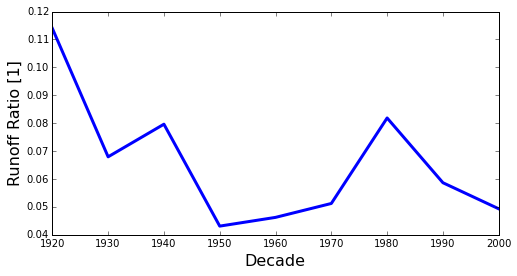

In [22]:
plt.figure(figsize=(8,4))
plt.plot(data4.index, data4.Q_P, lw =3)
plt.xlabel('Decade', fontsize=16)
plt.ylabel('Runoff Ratio [1]', fontsize = 16)
#plt.title('',fontsize = 14, fontweight='bold')
plt.savefig('./decadal_q_p.png', dpi=300, bbox_in='tight')

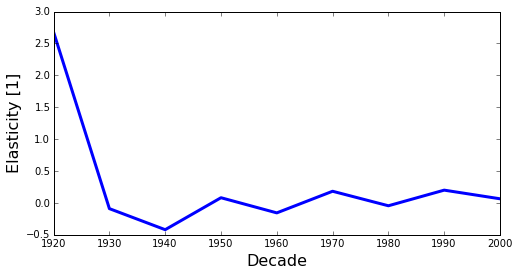

In [23]:
plt.figure(figsize=(8,4))
plt.plot(data4.index, data4.e, lw =3)
plt.xlabel('Decade', fontsize=16)
plt.ylabel('Elasticity [1]', fontsize = 16)
#plt.title('',fontsize = 14, fontweight='bold')
plt.savefig('./decadal_e.png', dpi=300, bbox_in='tight')

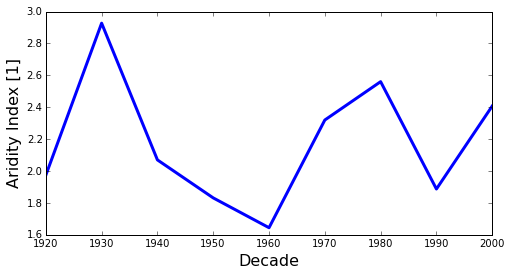

In [24]:
plt.figure(figsize=(8,4))
plt.plot(data4.index, data4.A, lw =3)
plt.xlabel('Decade', fontsize=16)
plt.ylabel('Aridity Index [1]', fontsize = 16)
#plt.title('',fontsize = 14, fontweight='bold')
plt.savefig('./decadal_A.png', dpi=300, bbox_in='tight')